## Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lifelines
from tqdm import tqdm
from sklearn.impute import KNNImputer

## Preprocessing

In [2]:
# files have an extra tab at the end resulting in an extra column
os = pd.read_csv("./data/GBM_OS_core.txt",sep="\t").iloc[:,:-1]
clinical = pd.read_csv("./data/GBM_clinical_core.txt",sep="\t").iloc[:,:-1]
cnv = pd.read_csv("./data/GBM_CNV_core.txt",sep="\t").iloc[:,:-1]
mrna = pd.read_csv("./data/GBM_mRNA_core.txt",sep="\t").iloc[:,:-1]

# 100 samples of size 168 used for bootstraping and validating the model
# each sample is split to training and testing
# testing datasets are used for calculating the c-index
train_bootstrap_idx = pd.read_csv("./data/GBM_train_sample_list.txt",sep="\t", header=None)
test_bootstrap_idx = pd.read_csv("./data/GBM_test_sample_list.txt",sep="\t", header=None)

In [3]:
os.head()

,feature,OS_OS,OS_vital_status
0,TCGA-12-1098,121,1
1,TCGA-12-1089,177,1
2,TCGA-06-0877,204,0
3,TCGA-16-1055,313,1
4,TCGA-14-1396,34,1


In [4]:
clinical.head()

,feature,age,gender,performance_score
0,TCGA-12-1098,75,FEMALE,60
1,TCGA-12-1089,64,MALE,[Not Available]
2,TCGA-06-0877,78,MALE,[Not Available]
3,TCGA-16-1055,48,MALE,[Not Available]
4,TCGA-14-1396,78,FEMALE,60


In [5]:
# column names have extra spaces
cnv.columns = np.vectorize(lambda x: x.strip(" "))(cnv.columns.values)
cnv.head()

,feature,CNV_3p,CNV_19p13.2,CNV_12p,CNV_12q,CNV_14q24.2,CNV_13q34,CNV_21q22.3,CNV_5q,CNV_5p,...,CNV_12q12,CNV_15q,CNV_7q21.2,CNV_13q14.2,CNV_6q22.31,CNV_2q22.1,CNV_12q14.1,CNV_4p,CNV_4q,CNV_17p13.1
0,TCGA-12-1098,0.0,-0.016516,0.769,0.769,0.000745,-0.003273,0.018575,0.716,0.716,...,0.768630,0.0,0.93577,-0.003273,-0.897910,0.000467,0.768630,0.0,0.0,-0.749130
1,TCGA-12-1089,0.0,-0.048613,0.000,0.000,-0.803270,-0.001663,-0.005399,0.000,0.000,...,0.001942,0.0,0.72834,-0.010094,0.011818,0.008753,3.656900,0.0,0.0,-0.013540
2,TCGA-06-0877,0.0,0.631440,0.713,0.713,-0.014373,-0.013391,-0.008892,0.000,0.000,...,0.709780,0.0,0.72163,0.002457,0.000000,0.657690,0.709780,0.0,0.0,-0.036849
3,TCGA-16-1055,0.0,0.229070,-0.688,0.000,0.006029,-0.022411,-0.044261,0.000,0.000,...,0.007281,0.0,1.26720,-0.719470,0.002973,0.000000,0.007281,0.0,0.0,-0.006489
4,TCGA-14-1396,0.0,-0.018639,0.648,0.648,-0.748200,-0.766920,-0.017666,0.643,0.643,...,0.648240,0.0,1.87580,-0.752880,-0.759830,0.004163,0.648240,0.0,0.0,-0.758400


In [6]:
mrna.iloc[:,1:] = KNNImputer(n_neighbors=3, weights="uniform").fit_transform(mrna.iloc[:,1:].T).T
mrna.head()

,feature,mRNA_ARHGEF10L,mRNA_HIF3A,mRNA_RNF17,mRNA_RNF10,mRNA_RNF11,mRNA_RNF12,mRNA_RNF13,mRNA_REM1,mRNA_C16orf14,...,mRNA_CLIP1,mRNA_NPY5R,mRNA_GNGT2,mRNA_GNGT1,mRNA_TULP3,mRNA_PTRF,mRNA_BCL6B,mRNA_GSTK1,mRNA_MRPL22,mRNA_SELS
0,TCGA-12-1098,2.341615,1.128923,0.212900,1.5845,0.4034,-0.366500,0.523333,0.908667,0.4458,...,0.2532,-1.3066,2.2110,-2.151364,-0.045857,-1.228385,0.787125,0.491500,-0.4224,0.145636
1,TCGA-12-1089,2.158769,3.727286,-0.124000,0.3761,1.1312,-0.638625,0.950000,-0.541667,-0.9562,...,1.0780,1.0201,1.1250,-3.514727,0.095857,-0.549231,1.135250,-0.222250,-0.6728,0.046909
2,TCGA-06-0877,1.747769,1.117714,-0.124909,0.6345,-0.1104,-1.357250,0.679667,0.334667,-0.2214,...,0.7018,-0.4125,1.1008,-2.293273,0.126286,1.091308,1.821875,0.165250,-0.2380,0.343727
3,TCGA-16-1055,1.743769,0.750071,-0.197727,-0.0764,1.7174,-0.347250,1.281000,0.362667,-1.0750,...,1.2609,1.3885,1.6650,-2.856455,0.341286,0.326769,2.100875,-0.058875,-0.7166,0.338000
4,TCGA-14-1396,1.440308,1.158429,0.087364,1.2241,1.1410,-0.158375,0.529000,0.120667,-0.0408,...,2.4547,-1.0094,0.8906,-1.814909,0.316714,1.147077,1.288625,0.381375,-0.2584,0.722364


In [7]:
train_bootstrap_idx.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,TCGA-14-0865,TCGA-14-1794,TCGA-32-1982,TCGA-16-1063,TCGA-12-1091,TCGA-41-3915,TCGA-19-1791,TCGA-12-3652,TCGA-12-1099,TCGA-06-0877,...,TCGA-28-1750,TCGA-19-2621,TCGA-28-1749,TCGA-06-1087,TCGA-19-1787,TCGA-14-0736,TCGA-16-1460,TCGA-27-1833,TCGA-14-0867,TCGA-28-1749
1,TCGA-19-2629,TCGA-27-1833,TCGA-15-1447,TCGA-06-2559,TCGA-12-1599,TCGA-12-1090,TCGA-16-1047,TCGA-41-4097,TCGA-32-1982,TCGA-14-1458,...,TCGA-12-0821,TCGA-32-1982,TCGA-12-1088,TCGA-14-1827,TCGA-12-3646,TCGA-27-2523,TCGA-06-0882,TCGA-41-2575,TCGA-28-1753,TCGA-19-0962
2,TCGA-12-1091,TCGA-28-1755,TCGA-28-2502,TCGA-14-0817,TCGA-28-1752,TCGA-16-0848,TCGA-14-0871,TCGA-41-2573,TCGA-32-2494,TCGA-14-1402,...,TCGA-32-2495,TCGA-16-0846,TCGA-19-2629,TCGA-14-2554,TCGA-19-1385,TCGA-14-1034,TCGA-27-2528,TCGA-27-2527,TCGA-02-2486,TCGA-19-2624
3,TCGA-14-0867,TCGA-14-0865,TCGA-27-1838,TCGA-41-3915,TCGA-12-1598,TCGA-02-2466,TCGA-06-2563,TCGA-19-1389,TCGA-32-1987,TCGA-19-1390,...,TCGA-06-1802,TCGA-06-2562,TCGA-12-1092,TCGA-32-4719,TCGA-32-2616,TCGA-12-1600,TCGA-12-1598,TCGA-26-1440,TCGA-19-1789,TCGA-06-0881
4,TCGA-16-1055,TCGA-32-4211,TCGA-06-1800,TCGA-19-1387,TCGA-16-0861,TCGA-14-1794,TCGA-41-3915,TCGA-12-0820,TCGA-32-4208,TCGA-12-0820,...,TCGA-32-1987,TCGA-14-0871,TCGA-02-2483,TCGA-26-1440,TCGA-15-1449,TCGA-27-2528,TCGA-12-1094,TCGA-27-1835,TCGA-16-0850,TCGA-19-1791


In [8]:
test_bootstrap_idx.head(5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,TCGA-41-2571,TCGA-32-4719,TCGA-27-2519,TCGA-06-1084,TCGA-27-2521,TCGA-19-1791,TCGA-32-2616,TCGA-19-2620,TCGA-27-2526,TCGA-12-3644,...,TCGA-12-3646,TCGA-06-0876,TCGA-02-2485,TCGA-27-1833,TCGA-06-2558,TCGA-32-1976,TCGA-06-1801,TCGA-19-2623,TCGA-14-1459,TCGA-32-2495
1,TCGA-02-2483,TCGA-41-4097,TCGA-12-0821,TCGA-12-1089,TCGA-14-1827,TCGA-12-1099,TCGA-12-3652,TCGA-32-2632,TCGA-06-0878,TCGA-32-2495,...,TCGA-06-0155,TCGA-32-4208,TCGA-28-2506,TCGA-12-1088,TCGA-06-2561,TCGA-16-0850,TCGA-14-1452,TCGA-14-2554,TCGA-14-0783,TCGA-06-2570
2,TCGA-14-1453,TCGA-14-1453,TCGA-06-0882,TCGA-28-2509,TCGA-12-1096,TCGA-06-2569,TCGA-14-0787,TCGA-12-0827,TCGA-32-2632,TCGA-12-1602,...,TCGA-32-1973,TCGA-32-2495,TCGA-06-2563,TCGA-41-3393,TCGA-06-1805,TCGA-28-1746,TCGA-19-1387,TCGA-32-2491,TCGA-14-1825,TCGA-14-1454
3,TCGA-12-1093,TCGA-27-2518,TCGA-16-1060,TCGA-41-2573,TCGA-41-2575,TCGA-02-2485,TCGA-06-0876,TCGA-32-4208,TCGA-32-2634,TCGA-14-1827,...,TCGA-19-0964,TCGA-41-3392,TCGA-06-0882,TCGA-12-3649,TCGA-06-0876,TCGA-19-0955,TCGA-06-2557,TCGA-19-1388,TCGA-19-1385,TCGA-06-1805
4,TCGA-14-1402,TCGA-28-1749,TCGA-16-0861,TCGA-12-0820,TCGA-19-0957,TCGA-12-0827,TCGA-06-2565,TCGA-28-2506,TCGA-28-2513,TCGA-14-0812,...,TCGA-14-0817,TCGA-12-0822,TCGA-28-1756,TCGA-41-3915,TCGA-19-2624,TCGA-14-0817,TCGA-19-1392,TCGA-06-2562,TCGA-32-1976,TCGA-19-2621


In [9]:
assert os.shape[0] == clinical.shape[0] == mrna.shape[0] == cnv.shape[0] # make sure they are the same shape
# make sure they contain same samples
assert (os["feature"] == clinical["feature"]).all()
assert (os["feature"] == mrna["feature"]).all()
assert (os["feature"] == cnv["feature"]).all()
print(f"Number of samples = {os.shape[0]}, Event = {os[os['OS_vital_status'] == 1].shape[0]}, Censored = {os[os['OS_vital_status'] == 0].shape[0]}")

Number of samples = 210, Event = 145, Censored = 65


In [10]:
os_clinical = pd.merge(os,clinical, on="feature",copy=False)
os_cnv = pd.merge(os,cnv, on="feature",copy=False)
os_mrna = pd.merge(os,mrna, on="feature",copy=False)
os_clinical_cnv = pd.merge(os_clinical,cnv, on="feature",copy=False)
os_clinical_mrna = pd.merge(os_clinical,mrna, on="feature",copy=False)
os_cnv_mrna = pd.merge(os_cnv,mrna, on="feature",copy=False)
os_clinical_cnv_mrna = pd.merge(os_clinical_cnv,mrna, on="feature",copy=False)

## Clinical

In [11]:
# Here, we make a model using the entire data
# I excluded performance_score because it contains missing values
# still not sure whether to use it or not
cphm = lifelines.CoxPHFitter()
cphm.fit(os_clinical.iloc[:,1:-1], event_col= "OS_vital_status", duration_col="OS_OS",formula="C(gender) + age")
cphm.check_assumptions(os_clinical.iloc[:,1:-1])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

Proportional hazard assumption looks okay.
C-index = 0.67


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
C(gender)[T.MALE],0.447,1.564,0.180,0.095,0.799,1.100,2.224,0.0,2.490,0.013,6.289
age,0.039,1.039,0.007,0.024,0.053,1.025,1.054,0.0,5.338,0.000,23.341


100%|██████████| 100/100 [00:06<00:00, 15.86it/s]


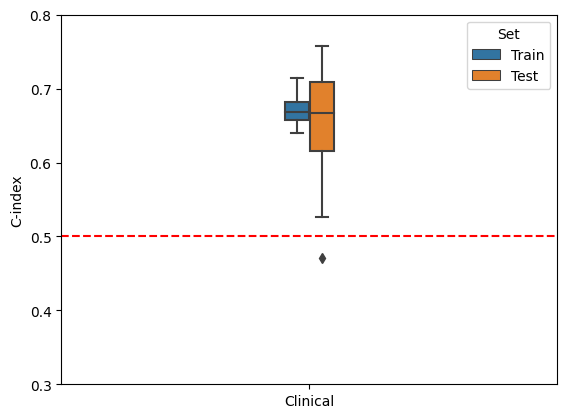

In [12]:
# The model used above uses the entire dataset but we need to make sure that it is valid
# we validate using the 100 splits and plot the c-index of the test set for each split
# if the median is nearly equal to the c-index of the entire dataset (above) with no outliers, then the model is correct
# It should also look similar to the one in the paper
clinical_c_index_train = []
clinical_c_index_test = []

for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_clinical[os_clinical["feature"].isin(train_bootstrap_idx[i].values)].iloc[:,1:-1]
    test_sample = os_clinical[os_clinical["feature"].isin(test_bootstrap_idx[i].values)].iloc[:,1:-1]
    cphm = lifelines.CoxPHFitter()
    # No performance_score
    cphm.fit(train_sample, event_col= "OS_vital_status", duration_col="OS_OS",formula="C(gender) + age")
    clinical_c_index_train.append(cphm.concordance_index_)
    clinical_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

clinical_c_index_train = np.array(clinical_c_index_train)
clinical_c_index_test = np.array(clinical_c_index_test)

stacked = np.hstack([clinical_c_index_train,clinical_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
clinical_results_df = pd.DataFrame({
    "Feature": ["Clinical"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(clinical_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["Clinical"])
plt.xlabel("")
plt.show()

## CNV

In [13]:
# CNV contains lots of variables, so we need to use lasso regularization to perform feature selection
# l1_ratio=1.0 is for lasso, penalizer=0.01 is for the weight
# penalizer value should be cross validated but i just chose a random value for now 
cphm = lifelines.CoxPHFitter(penalizer=0.01, l1_ratio=1.0)
cphm.fit(os_cnv.iloc[:,1:], event_col= "OS_vital_status", duration_col="OS_OS")
cphm.check_assumptions(os_cnv.iloc[:,1:])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary[cphm.summary["p"] <= 0.05].round(3)

Proportional hazard assumption looks okay.
C-index = 0.78


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
CNV_7p11.2,0.236,1.266,0.116,0.008,0.464,1.008,1.590,0.0,2.028,0.043,4.554
CNV_19p,-1.354,0.258,0.514,-2.362,-0.346,0.094,0.707,0.0,-2.633,0.008,6.886
CNV_6p,-1.893,0.151,0.964,-3.783,-0.003,0.023,0.997,0.0,-1.963,0.050,4.333
CNV_1p32.3,-1.180,0.307,0.465,-2.091,-0.269,0.124,0.764,0.0,-2.539,0.011,6.493
CNV_Xq,4.148,63.304,1.870,0.483,7.813,1.621,2472.263,0.0,2.218,0.027,5.236
CNV_2q22.1,-4.231,0.015,1.662,-7.489,-0.973,0.001,0.378,0.0,-2.545,0.011,6.518


100%|██████████| 100/100 [02:38<00:00,  1.58s/it]


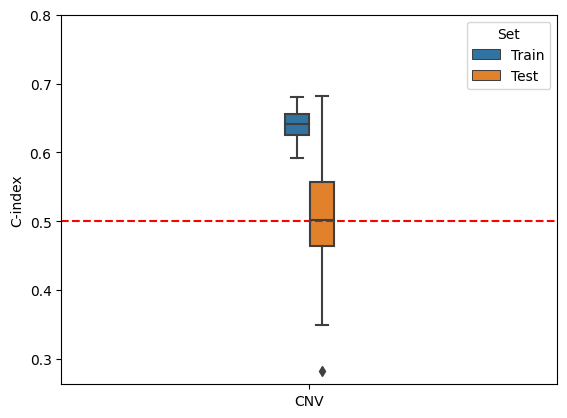

In [14]:
# Same setup as before
# From the plots we notice that the median of the splits is not equal to the entire dataset
# meaning that the model above is not correct
# the plot is very similar to the paper
cnv_c_index_train = []
cnv_c_index_test = []
for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_cnv[os_cnv["feature"].isin(train_bootstrap_idx[i].values)].iloc[:,1:]
    test_sample = os_cnv[os_cnv["feature"].isin(test_bootstrap_idx[i].values)].iloc[:,1:]
    cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample, event_col= "OS_vital_status", duration_col="OS_OS")
    cnv_c_index_train.append(cphm.concordance_index_)
    cnv_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

cnv_c_index_train = np.array(cnv_c_index_train)
cnv_c_index_test = np.array(cnv_c_index_test)

stacked = np.hstack([cnv_c_index_train,cnv_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
cnv_results_df = pd.DataFrame({
    "Feature": ["CNV"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(cnv_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["CNV"])
plt.xlabel("")
plt.show()

## mRNA

In [15]:
# We ran the model on each column separately to reduce the number of columns as the
# multivariable model with all columns did not converge due to having lots of columns 
significant_cols = [
    "mRNA_LOC155006",
    "mRNA_RPP30",
    "mRNA_LMNA",
    "mRNA_MICALL2",
]

cphm = lifelines.CoxPHFitter()
cphm.fit(os_mrna[["OS_OS","OS_vital_status",*significant_cols]], event_col= "OS_vital_status", duration_col="OS_OS")
cphm.check_assumptions(os_mrna[["OS_OS","OS_vital_status",*significant_cols]])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

Proportional hazard assumption looks okay.
C-index = 0.64


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mRNA_LOC155006,-0.484,0.616,0.146,-0.771,-0.198,0.462,0.821,0.0,-3.310,0.001,10.064
mRNA_RPP30,-0.226,0.798,0.260,-0.735,0.283,0.480,1.327,0.0,-0.869,0.385,1.378
mRNA_LMNA,0.321,1.379,0.181,-0.034,0.677,0.966,1.967,0.0,1.771,0.076,3.709
mRNA_MICALL2,0.214,1.238,0.142,-0.065,0.492,0.937,1.636,0.0,1.504,0.133,2.916


100%|██████████| 100/100 [00:39<00:00,  2.51it/s]


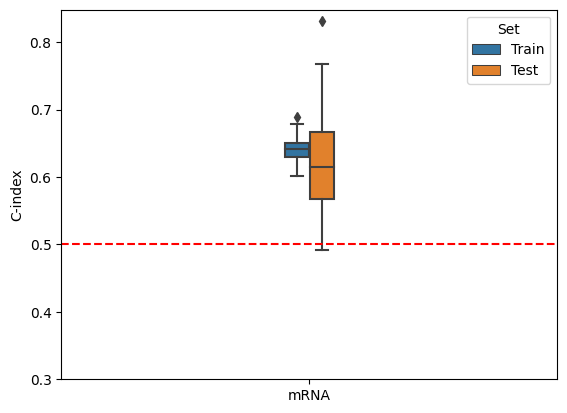

In [16]:
mrna_c_index_train = []
mrna_c_index_test = []

for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_mrna[os_mrna["feature"].isin(train_bootstrap_idx[i].values)].iloc[:,1:]
    test_sample = os_mrna[os_mrna["feature"].isin(test_bootstrap_idx[i].values)].iloc[:,1:]
    cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample[["OS_OS","OS_vital_status",*significant_cols]], event_col= "OS_vital_status", duration_col="OS_OS")
    mrna_c_index_train.append(cphm.concordance_index_)
    mrna_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

mrna_c_index_train = np.array(mrna_c_index_train)
mrna_c_index_test = np.array(mrna_c_index_test)

stacked = np.hstack([mrna_c_index_train,mrna_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
mrna_results_df = pd.DataFrame({
    "Feature": ["mrna"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(mrna_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["mRNA"])
plt.xlabel("")
plt.show()

## Clinical + CNV

In [17]:
cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
cphm.fit(os_clinical_cnv.iloc[:,1:], event_col= "OS_vital_status", duration_col="OS_OS", formula=f"age + C(gender) {' '.join(['+ ' + col for col in cnv.columns[1:]])}")
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

C-index = 0.70


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
C(gender)[T.MALE],0.130,1.139,0.181,-0.224,0.484,0.799,1.623,0.0,0.719,0.472,1.082
CNV_10p,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.001
CNV_10p11.23,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
CNV_10p13,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
CNV_10p15.3,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
CNV_9q,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.000
CNV_9q34.2,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
CNV_Xp22.2,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.000


100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


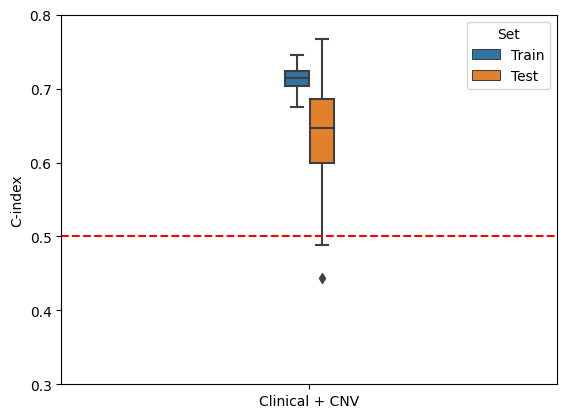

In [18]:
clinical_cnv_c_index_train = []
clinical_cnv_c_index_test = []
for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_clinical_cnv[os_clinical_cnv["feature"].isin(train_bootstrap_idx[i].values)].iloc[:,1:]
    test_sample = os_clinical_cnv[os_clinical_cnv["feature"].isin(test_bootstrap_idx[i].values)].iloc[:,1:]
    cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample, event_col= "OS_vital_status", duration_col="OS_OS", formula=f"age + C(gender) {' '.join(['+ ' + col for col in cnv.columns[1:]])}")
    clinical_cnv_c_index_train.append(cphm.concordance_index_)
    clinical_cnv_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

clinical_cnv_c_index_train = np.array(clinical_cnv_c_index_train)
clinical_cnv_c_index_test = np.array(clinical_cnv_c_index_test)

stacked = np.hstack([clinical_cnv_c_index_train,clinical_cnv_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
clinical_cnv_results_df = pd.DataFrame({
    "Feature": ["Clinical + CNV"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(clinical_cnv_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["Clinical + CNV"])
plt.xlabel("")
plt.show()

## Clinical + mRNA

In [19]:
cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
cphm.fit(os_clinical_mrna[["OS_OS","OS_vital_status", "age", "gender" ,*significant_cols]], event_col= "OS_vital_status", duration_col="OS_OS", formula=f"age + C(gender) {' '.join(['+ ' + col for col in significant_cols])}")
cphm.check_assumptions(os_clinical_mrna[["OS_OS","OS_vital_status", "age", "gender" ,*significant_cols]])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

Proportional hazard assumption looks okay.
C-index = 0.71


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
C(gender)[T.MALE],0.092,1.096,0.177,-0.255,0.439,0.775,1.551,0.0,0.518,0.605,0.726
age,0.024,1.025,0.007,0.011,0.038,1.011,1.039,0.0,3.473,0.001,10.923
mRNA_LMNA,0.216,1.241,0.159,-0.097,0.528,0.908,1.696,0.0,1.352,0.176,2.503
mRNA_LOC155006,-0.299,0.742,0.153,-0.599,0.001,0.550,1.001,0.0,-1.951,0.051,4.292
mRNA_MICALL2,0.000,1.000,0.114,-0.223,0.223,0.800,1.250,0.0,0.001,1.000,0.001
mRNA_RPP30,-0.000,1.000,0.008,-0.015,0.015,0.985,1.016,0.0,-0.006,0.995,0.007


100%|██████████| 100/100 [00:49<00:00,  2.01it/s]


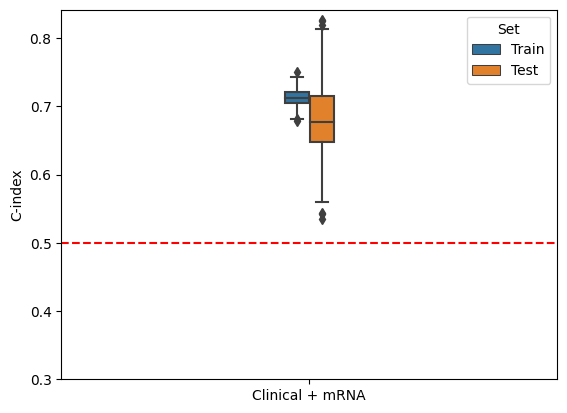

In [20]:
clinical_mrna_c_index_train = []
clinical_mrna_c_index_test = []

for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_clinical_mrna[os_clinical_mrna["feature"].isin(train_bootstrap_idx[i].values)].iloc[:,1:]
    test_sample = os_clinical_mrna[os_clinical_mrna["feature"].isin(test_bootstrap_idx[i].values)].iloc[:,1:]
    cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample[["OS_OS","OS_vital_status", "age", "gender" ,*significant_cols]], event_col= "OS_vital_status", duration_col="OS_OS", formula=f"age + C(gender) {' '.join(['+ ' + col for col in significant_cols])}")
    clinical_mrna_c_index_train.append(cphm.concordance_index_)
    clinical_mrna_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

clinical_mrna_c_index_train = np.array(clinical_mrna_c_index_train)
clinical_mrna_c_index_test = np.array(clinical_mrna_c_index_test)

stacked = np.hstack([clinical_mrna_c_index_train,clinical_mrna_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
clinical_mrna_results_df = pd.DataFrame({
    "Feature": ["Clinical + mRNA"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(clinical_mrna_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["Clinical + mRNA"])
plt.xlabel("")
plt.show()

## CNV + mRNA

In [21]:
cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
cphm.fit(os_cnv_mrna[[*significant_cols,"OS_OS","OS_vital_status",*cnv.columns[1:]]], event_col= "OS_vital_status", duration_col="OS_OS")
cphm.check_assumptions(os_cnv_mrna[[*significant_cols,"OS_OS","OS_vital_status",*cnv.columns[1:]]])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

Proportional hazard assumption looks okay.
C-index = 0.67


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
mRNA_LOC155006,-0.289,0.749,0.150,-0.583,0.004,0.558,1.004,0.0,-1.931,0.053,4.226
mRNA_RPP30,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.001
mRNA_LMNA,0.203,1.226,0.176,-0.141,0.548,0.868,1.730,0.0,1.157,0.247,2.015
mRNA_MICALL2,0.083,1.086,0.147,-0.206,0.371,0.814,1.449,0.0,0.562,0.574,0.801
CNV_3p,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
CNV_2q22.1,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.000
CNV_12q14.1,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
CNV_4p,0.000,1.000,0.000,-0.001,0.001,0.999,1.001,0.0,0.000,1.000,0.001


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


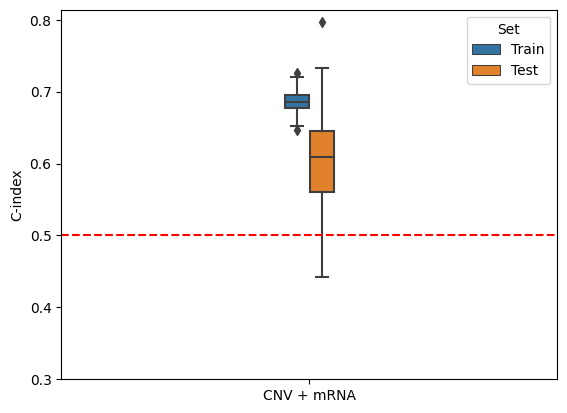

In [22]:
cnv_mrna_c_index_train = []
cnv_mrna_c_index_test = []
for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_cnv_mrna[os_cnv_mrna["feature"].isin(train_bootstrap_idx[i].values)][[*significant_cols,"OS_OS","OS_vital_status",*cnv.columns[1:]]]
    test_sample = os_cnv_mrna[os_cnv_mrna["feature"].isin(test_bootstrap_idx[i].values)][[*significant_cols,"OS_OS","OS_vital_status",*cnv.columns[1:]]]
    cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample, event_col= "OS_vital_status", duration_col="OS_OS")
    cnv_mrna_c_index_train.append(cphm.concordance_index_)
    cnv_mrna_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

cnv_mrna_c_index_train = np.array(cnv_mrna_c_index_train)
cnv_mrna_c_index_test = np.array(cnv_mrna_c_index_test)

stacked = np.hstack([cnv_mrna_c_index_train,cnv_mrna_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
cnv_mrna_results_df = pd.DataFrame({
    "Feature": ["CNV + mRNA"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(cnv_mrna_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["CNV + mRNA"])
plt.xlabel("")
plt.show()

## Clinical + CNV + mRNA

In [23]:
cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
cphm.fit(os_clinical_cnv_mrna[[*significant_cols, "age", "gender" ,"OS_OS","OS_vital_status",*cnv.columns[1:]]], event_col= "OS_vital_status", duration_col="OS_OS", formula=f"age + C(gender) {' '.join(['+ ' + col for col in cnv.columns[1:]])} {' '.join(['+ ' + col for col in significant_cols])}")
cphm.check_assumptions(os_clinical_cnv_mrna[[*significant_cols, "age", "gender","OS_OS","OS_vital_status",*cnv.columns[1:]]])
print(f"C-index = {cphm.concordance_index_:.2f}")
cphm.summary.round(3)

Proportional hazard assumption looks okay.
C-index = 0.73


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
C(gender)[T.MALE],0.065,1.067,0.182,-0.291,0.421,0.747,1.524,0.0,0.358,0.720,0.473
CNV_10p,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
CNV_10p11.23,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.000
CNV_10p13,0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,0.000,1.000,0.000
CNV_10p15.3,-0.000,1.000,0.000,-0.000,0.000,1.000,1.000,0.0,-0.000,1.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...
age,0.026,1.026,0.007,0.011,0.040,1.011,1.040,0.0,3.537,0.000,11.273
mRNA_LMNA,0.215,1.240,0.140,-0.058,0.489,0.943,1.630,0.0,1.541,0.123,3.021
mRNA_LOC155006,-0.309,0.734,0.151,-0.604,-0.013,0.547,0.987,0.0,-2.048,0.041,4.624


100%|██████████| 100/100 [03:05<00:00,  1.86s/it]


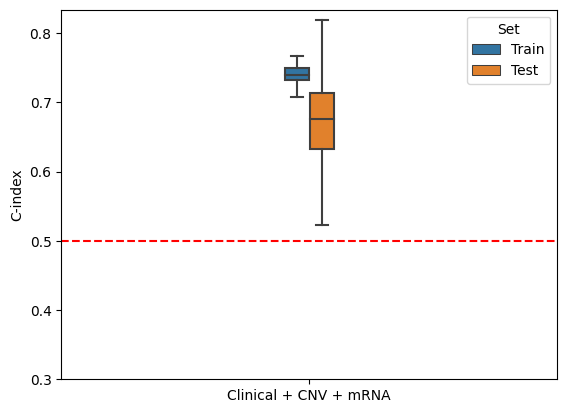

In [24]:
clinical_cnv_mrna_c_index_train = []
clinical_cnv_mrna_c_index_test = []
for i in tqdm(range(train_bootstrap_idx.shape[1])):
    train_sample = os_clinical_cnv_mrna[os_clinical_cnv_mrna["feature"].isin(train_bootstrap_idx[i].values)][[*significant_cols, "age", "gender" ,"OS_OS","OS_vital_status",*cnv.columns[1:]]]
    test_sample = os_clinical_cnv_mrna[os_clinical_cnv_mrna["feature"].isin(test_bootstrap_idx[i].values)][[*significant_cols, "age", "gender" ,"OS_OS","OS_vital_status",*cnv.columns[1:]]]
    cphm = lifelines.CoxPHFitter(penalizer=0.1, l1_ratio=1.0)
    cphm.fit(train_sample, event_col= "OS_vital_status", duration_col="OS_OS", formula=f"age + C(gender) {' '.join(['+ ' + col for col in cnv.columns[1:]])} {' '.join(['+ ' + col for col in significant_cols])}")
    clinical_cnv_mrna_c_index_train.append(cphm.concordance_index_)
    clinical_cnv_mrna_c_index_test.append(lifelines.utils.concordance_index(test_sample['OS_OS'], -cphm.predict_partial_hazard(test_sample), test_sample['OS_vital_status']))

clinical_cnv_mrna_c_index_train = np.array(clinical_cnv_mrna_c_index_train)
clinical_cnv_mrna_c_index_test = np.array(clinical_cnv_mrna_c_index_test)

stacked = np.hstack([clinical_cnv_mrna_c_index_train,clinical_cnv_mrna_c_index_test])
both_sets = np.vstack([stacked,["Train"]*100 + ["Test"]*100]).T
clinical_cnv_mrna_results_df = pd.DataFrame({
    "Feature": ["Clinical + CNV + mRNA"] * 200,
    "C-index": both_sets[:,0].astype(float),
    "Set": both_sets[:,1]
})
sns.boxplot(clinical_cnv_mrna_results_df, x="Feature", y="C-index", width=0.1, whis=1.5, hue="Set")
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1))
plt.axhline(0.5,linestyle='dashed',color='red')
plt.xticks([0],["Clinical + CNV + mRNA"])
plt.xlabel("")
plt.show()

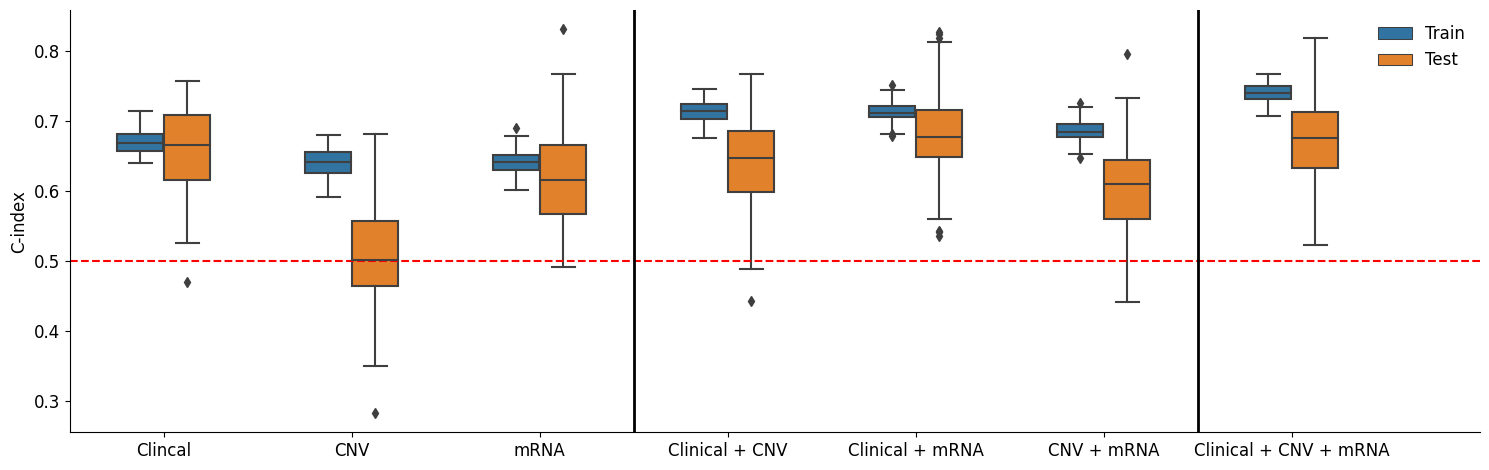

In [35]:
concat_df = pd.concat([clinical_results_df,cnv_results_df,mrna_results_df,clinical_cnv_results_df,clinical_mrna_results_df, cnv_mrna_results_df ,clinical_cnv_mrna_results_df])

sns.boxplot(concat_df, x="Feature", y="C-index", width=0.5, whis=1.5, hue="Set")
plt.xticks([0,1,2,3,4,5,6],["Clincal", "CNV" , "mRNA", "Clinical + CNV","Clinical + mRNA","CNV + mRNA","Clinical + CNV + mRNA"],fontsize=12)
plt.yticks(np.linspace(0.3,0.8,6),labels=np.linspace(0.3,0.8,6).round(1),fontsize=12)
plt.axhline(0.5,linestyle='dashed',color='red')
plt.axvline(2.5,linewidth=2,c="black")
plt.axvline(5.5,linewidth=2,c="black")
plt.xlim(-0.5,7)
plt.gca().spines[['right', 'top']].set_visible(False)
plt.ylabel("C-index",fontsize=12)
plt.xlabel("")
plt.legend(loc="upper right",fontsize=12,frameon=False)
plt.gcf().set_figwidth(15)
plt.tight_layout()
plt.show()